# Hälsostudie

Vi vill använda oss av statistik inferens för att denna hälsostudie med information om deltagarnas ålder, kön, vikt, längd, blodtryck, kolesterolnivå, rökvanor och om de har en viss sjukdom för att göra analys och dra statistiksa slutsatser om deras hälsotillstånd.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.power import TTestIndPower
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from helpers import DatasetHelper, HealthSimulator, ConfidenceIntervalCalculator, HypothesisTester

## Förhandsgranska data

Vi vill börja förhandsgranska våra data för att få en första förståelse av hur datasetet ser ut och om det finns eventuella problem.
Genom att använda df.head(), df.describe() och df.info() kan vi se exempel på observationer, få en statistisk sammanfattning samt information om datatyper och antal värden.
Med df.isna().sum() undersöker vi dessutom om det finns saknade värden som kan behöva hanteras innan vidare analys.

**Källa**: *Videolektioner från kursen Pythonprogrammering och statistisk dataanalys*

In [2]:
dh = DatasetHelper("health_study_dataset.csv")
dh.load_data()
dh.preview()
dh.summary()
dh.info()
dh.missing_values()

Data laddades från health_study_dataset.csv


,id,age,sex,height,weight,systolic_bp,cholesterol,smoker,disease
0,1,57,F,168.9,65.8,141.8,4.58,No,0
1,2,47,M,180.4,95.9,144.8,5.18,Yes,0
2,3,59,F,169.9,82.2,151.7,6.16,No,0
3,4,72,M,157.7,93.1,151.0,6.63,No,0
4,5,46,M,192.6,104.1,144.1,5.21,No,0


,id,age,height,weight,systolic_bp,cholesterol,disease
count,800.0000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,400.5000,49.426250,171.849250,73.413000,149.178625,4.929150,0.058750
std,231.0844,14.501118,9.804259,13.685059,12.793360,0.848413,0.235303
min,1.0000,18.000000,144.400000,33.700000,106.800000,2.500000,0.000000
25%,200.7500,39.000000,164.775000,64.800000,140.900000,4.327500,0.000000
50%,400.5000,50.000000,171.350000,73.200000,149.400000,4.970000,0.000000
75%,600.2500,59.000000,178.925000,82.600000,157.600000,5.482500,0.000000
max,800.0000,90.000000,200.400000,114.400000,185.900000,7.880000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           800 non-null    int64  
 1   age          800 non-null    int64  
 2   sex          800 non-null    object 
 3   height       800 non-null    float64
 4   weight       800 non-null    float64
 5   systolic_bp  800 non-null    float64
 6   cholesterol  800 non-null    float64
 7   smoker       800 non-null    object 
 8   disease      800 non-null    int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 56.4+ KB


None

id             0
age            0
sex            0
height         0
weight         0
systolic_bp    0
cholesterol    0
smoker         0
disease        0
dtype: int64

## Beskrivande analys

Vi vill undersöka våra data genom en beskrivande analys för att få en överblick över centrala mått och fördelningar.
Vi vill därför räkna ut medelvärde, median, minimum och maximum för variablerna age, weight, height, systolic_bp och cholesterol.
Dessutom vill vi visualisera resultaten genom tre olika grafer som ger en översikt över rökning, blodtryck och vikt hos populationen från datasetet. 

**Källa**: *Videolektioner från kursen Pythonprogrammering och statistisk dataanalys*, *[Geeks for Geeks](https://www.geeksforgeeks.org/python/how-to-make-a-table-in-python/)*

### Översikt - Statistik för hälsodata

In [3]:
total_participants = dh.df["id"].count()
print(f"Totalt antal deltagare i studien: {total_participants} personer")

# Tar fram statistik för hälsodata
columns = ["age", "weight", "height", "systolic_bp", "cholesterol"]
data = dh.df[columns]

statistics = pd.DataFrame({
    "Medel": data.mean(),
    "Median": data.median(),
    "Min": data.min(),
    "Max": data.max()
}).round(2)

statistics.style \
    .set_caption("<h2> Översikt - Statistik för hälsodata") \
    .format("{:.2f}")

Totalt antal deltagare i studien: 800 personer


,Medel,Median,Min,Max
age,49.43,50.00,18.00,90.00
weight,73.41,73.20,33.70,114.40
height,171.85,171.35,144.40,200.40
systolic_bp,149.18,149.40,106.80,185.90
cholesterol,4.93,4.97,2.50,7.88


### Översikt över rökning, blodtryck och vikt

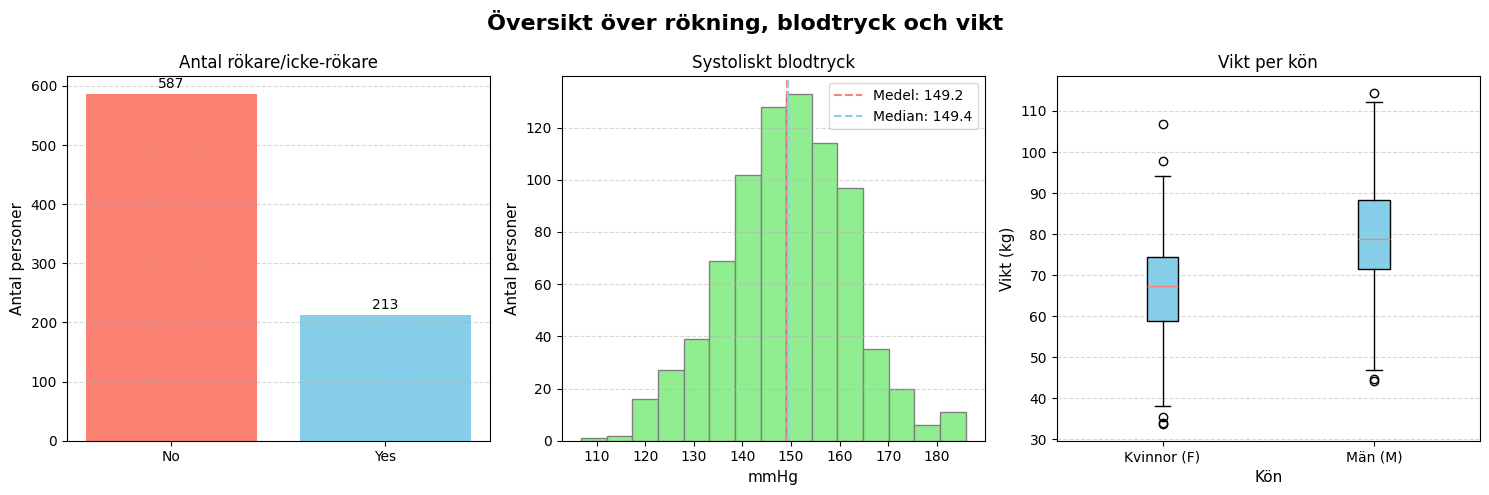

In [4]:
# Skapar en figure med 1 rad och 3 kolumner (grafer)
# ========================
figs, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=False, sharey=False)

# SUBPLOT 1: Bar chart för rökare
# ========================
ax1 = axes[0]
counts = dh.df["smoker"].value_counts()
bars = ax1.bar(counts.index, counts.values, color=['salmon', 'skyblue'])

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 5, str(int(height)),
             ha='center', va='bottom', fontsize=10)

ax1.set_title("Antal rökare/icke-rökare", fontsize=12)
ax1.set_ylabel("Antal personer", fontsize=11)
ax1.grid(True, axis="y", linestyle="--", alpha=0.5)
ax1.tick_params(axis='x')

# SUBPLOT 2: Histogram systoliskt blodtryck
# ========================
ax2 = axes[1]
ax2.hist(dh.df["systolic_bp"], bins=15, color="lightgreen", edgecolor="grey")

mean_bp = dh.df["systolic_bp"].mean()
median_bp = dh.df["systolic_bp"].median()

ax2.axvline(mean_bp, color='salmon', linestyle='dashed', linewidth=1.5, label=f'Medel: {mean_bp:.1f}')
ax2.axvline(median_bp, color='skyblue', linestyle='dashed', linewidth=1.5, label=f'Median: {median_bp:.1f}')

ax2.set_title("Systoliskt blodtryck", fontsize=12)
ax2.set_xlabel("mmHg", fontsize=11)
ax2.set_ylabel("Antal personer", fontsize=11)
ax2.grid(True, axis="y", linestyle="--", alpha=0.5)
ax2.legend()

# SUBPLOT 3: Boxplot över vikt per kön
# ========================
ax3 = axes[2]
ax3.boxplot(
    [dh.df.loc[dh.df['sex'] == 'F', 'weight'], 
     dh.df.loc[dh.df['sex'] == 'M', 'weight']],
    tick_labels=["Kvinnor (F)", "Män (M)"],
    patch_artist=True,
    boxprops=dict(facecolor='skyblue', color='black'),
    medianprops=dict(color='salmon', linewidth=1)
)

ax3.set_title("Vikt per kön", fontsize=12)
ax3.set_xlabel("Kön", fontsize=11)
ax3.set_ylabel("Vikt (kg)", fontsize=11)
ax3.grid(True, axis="y", linestyle="--", alpha=0.5)

plt.suptitle("Översikt över rökning, blodtryck och vikt", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Individer med sjukdomen

Vi vill undersöka andelen personer i vårt dataset som har sjukdomen och vidare ta reda på hur sannolikt det är att insjukna. Analysen kommer att titta på om det finns någon skilland mellan män och kvinnor.

För att ta reda på hur stor sannolikheten är att bli sjuk så vill vi med hjälp av NumPy simulera 1000 slumpmässigt valda personer med samma sannolikhet för sjukdom.

**Källa**: *Videolektioner från kursen Pythonprogrammering och statistisk dataanalys*, *[Geeks for Geeks - Pie Chart](https://www.geeksforgeeks.org/data-science/plot-a-pie-chart-in-python-using-matplotlib/)*, *[Geeks for geeks - random.seed()](https://www.geeksforgeeks.org/python/random-seed-in-python/)*

### Andel personer med och utan sjukdomen

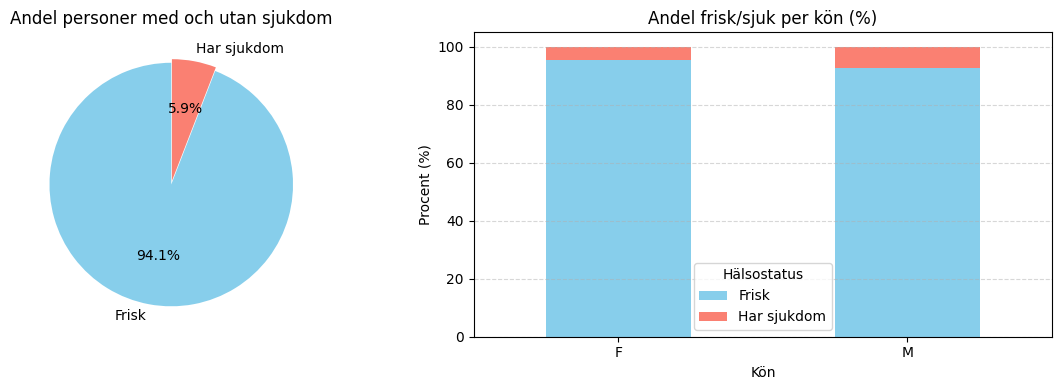

In [5]:
disease_counts = dh.df["disease"].value_counts().sort_index()
gender_disease = dh.df.groupby(["sex", "disease"]).size().unstack(fill_value=0)
gender_disease_percent = gender_disease.div(gender_disease.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Subplot 1 – Andel sjuk/frisk
# ========================
axes[0].pie(
    disease_counts.values,
    labels=["Frisk", "Har sjukdom"],
    autopct="%1.1f%%",
    colors=["skyblue", "salmon"],
    startangle=90,
    explode=(0, 0.03)
)
axes[0].set_title("Andel personer med och utan sjukdom", fontsize=12)

# Subplot 2 – Staplat procentdiagram per kön
# ========================
gender_disease_percent.plot(
    kind="bar",
    stacked=True,
    ax=axes[1],
    color=["skyblue", "salmon"]
)

axes[1].set_title("Andel frisk/sjuk per kön (%)", fontsize=12)
axes[1].set_xlabel("Kön")
axes[1].set_ylabel("Procent (%)")
axes[1].legend(["Frisk", "Har sjukdom"], title="Hälsostatus")
axes[1].tick_params(axis='x', rotation=0)
axes[1].grid(True, axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

### Sanolikheten att insjukna

Vi vill ta reda på hur väl en slumpmässig simulering av 1000 personer (baserad på den observerade sannolikheten för sjukdom) stämmer överens med den verkliga andelen i datasetet. Vi vill även titta på om det finns skillander mellan män och kvinnor risk att insjukna. För att göra detta använder vi oss av klassen `HealthSimulator`. 

**Källa**: *Videolektioner från kursen Pythonprogrammering och statistisk dataanalys*, *[Geeks for geeks - Python Classes and Objects](https://www.geeksforgeeks.org/python/python-classes-and-objects/)*, *[PEP 257 - Docstring Conventions](https://peps.python.org/pep-0257/)*

In [6]:
sim = HealthSimulator(dh.df, disease_col="disease", group_col="sex", random_state=42)

sim.compute_true_proportions()  
sim.simulate(n=1000)
sim.print_report()

Verkliga andelar
Andelen med sjukdomen:              5.9%
Andel F med sjukdom:                4.5%
Andel M med sjukdom:                7.3%

Simulerade andelar
Simulerad andel med sjukdom:        5.6%
Simulerad andel F:                  5.5%
Simulerad andel M:                  7.4%

Jämförelse
Total skillnad:                     0.27%
Skillnad F:                         1.0%
Skillnad M:                         0.1%


## Konfidensintervall

Vi vill vidare undersöka medelvärdet av systoliskt blodtryck i vårt stickprov och hur osäkert detta estimat är.
Vi vill därför beräkna ett 95 % konfidensintervall för det sanna medelvärdet i populationen.
För att göra detta använder vi metoderna normalapproximation och bootstrap och jämför resultaten.
Normalapproximation bygger på teoretiska antaganden om att datan är normalfördelade. Används bäst när stickprovet är stort (n > 40) och datan verkar konsekvent. 
Bootstrap å andra sidan simulerar osäkerheten genom att upprepade gånger dra nya stickprov (med återläggning) ur datasetet, vilket är en metod som fungerar bra även för små eller skeva dataset.

**Källa**: *Videolektioner från kursen Pythonprogrammering och statistisk dataanalys*, *[Geeks for geeks - How to Calculate Confidence Intervals in Python?](https://www.geeksforgeeks.org/python/how-to-calculate-confidence-intervals-in-python/)*, *[MIT OpenCourseWare](https://ocw.mit.edu/courses/14-310x-data-analysis-for-social-scientists-spring-2023/resources/14310x-lecture-13_mp4/)*

In [7]:
calc = ConfidenceIntervalCalculator(dh.df["systolic_bp"])
calc.print_report()

Punktestimat (medelvärde):    149.2 mmHg
Standardfel:                  0.452 mmHg
95% CI (normalapproximation): [148.3, 150.1] mmHg
95% CI (bootstrap):           [148.3, 150.1] mmHg


### Jämförelse
De två olika metoderna, normalapproximation och bootstrap, ger samma resultat. Det innebär att fördelningen av stickprovsmedelvärden sannolikt är ungefär normal och att standardfelet troligen beräknats korrekt.
Med andra ord bekräftar bootstrapen att normalapproximation fungerar att använda för datasetet. 

## Hypotesprövning

Med hjälp av datasetet vill vi undersöka om rökning påverkar det systoliska blodtrycket hos en person.
Vi utgår ifrån vår **nollhypotes (H₀)** att rökare och icke-rökare har samma genomsnittliga systoliska blodtryck.
Där vår **alternativa hypotes (H₁)** är att rökare har högre genomsnittligt systoliskt blodtryck.

**Metod**: 

Welchs T-test har valts som metod, över standard T-test, för att utf;ra hypotesprövningen. Welchs T-test är mer lämpligt eftersom data över blodtrycksvärden är kontinuerliga och vi vill därför utgå ifrån ett medelvärde snarare än en andel. Welchs T-test utgår ifrån att båda grupperna inte har lika varians och är ett mer robust test att använda i praktiska analyser. Eftersom vi misstänker att rökare har högre blodtryck gör vi både ett tvåsidigt och ett riktat ensidigt test.

- *T-värde*: anger hur många standardfel skillanden mellan gruppernas medelvärde ligger från noll, ett t-värde nära 0 tolkas som liten skillnad.
- *P-värde*: är ett konfidensvärde (0-1) som ger en indikation på hur säkra vi kan vara på ett reslutat över ett annat, desto närmre noll desto säkrare, 0.05 används ofta som gräns för signifikans. 

**Effektstorlek och power**:

Vi vill även undersöka hur säkert hypotesttestet är och dess verkliga betydelse. För det kommer vi att använda oss av två metoder. För att beskriva hur stor skillnaden är mellan medelvärden i blodtryck i enheter av starndardavvikelser hos rökare (grupp 1) och icke-rökare (grupp 2) används Cohen's d metod. Vidare mäts den statistiska styrkan hos hypotesprövningen med hjälp av en power-analys (ensidigt och tvåsidigt). Den statistiska styrkan anger sannolikheten att förkasta en nollhypotes eller sannolikheten att acceptera den alternativa hypotesen om den är sann. Standardmåttet för statisisk styrka brukar normalt sett vara ≥0.8. 

**Källa**: *Videolektioner från kursen Pythonprogrammering och statistisk dataanalys*, *[MIT OpenCourseWare](https://ocw.mit.edu/courses/14-310x-data-analysis-for-social-scientists-spring-2023/resources/14310x-lecture-13_mp4/)*, *[Geeks for geeks - Effect size](https://www.geeksforgeeks.org/maths/effect-size/)*, *[Geeks for geeks - Introduction to Power Analysis in Python](https://www.geeksforgeeks.org/python/introduction-to-power-analysis-in-python/)*

In [8]:
smokers = dh.df[dh.df["smoker"] == "Yes"]["systolic_bp"].dropna()
nonsmokers = dh.df[dh.df["smoker"] == "No"]["systolic_bp"].dropna()

tester = HypothesisTester(smokers, nonsmokers)

tester.compute_test()
tester.compute_effect_size()
tester.compute_power(alpha=0.05)

tester.print_report()

Medelvärde grupp 1:   149.52
Medelvärde grupp 2:   149.05
t-värde:              0.450
p-värde (tvåsidigt):  0.653
p-värde (ensidigt):   0.326
Cohen's d:            0.036
Power (tvåsidigt):    0.543
Power (ensidigt):     0.676


### Tolkning av resultatet

Ett **t-värde** på 0.450 är väldigt nära noll, vilket betyder att skillnaden i blodtryck mellan rökare och icke-rökare är mycket liten i förhållande till variationen i data.

Det **tvåsidiga p-värdet** (0.653) är mycket högt, vilket betyder att vi har liten statistisk evidens för att rökare och icke-rökare skiljer sig åt i blodtryck. Det **ensidiga p-testet** (0.326) testar den riktade hypotesen (att rökare skulle ha högre blodtryck än icke-rökare), eftersom resultatet fortfarande är mycket högre än gränsen för signifikans (0.05), så går det inte att förkasta nollhypotesen.

**Cohen's d** visar att skillnaden mellan de två grupperna är nästan obefintlig, och man kan säga att grupperna har mycket lika värden för systoliskt blodtryck. 

**Power-analysen** visar för det *tvåsidiga testet* att undersökningen har en medelstor effekt (0.543), däremot ligger det långt från det önskvärda måttet på ≥0.8. Det *ensidiga testet* visar en högre power, men även med detta testet är chansen att missa en verklig skillnad fortfarande relativt hög.

**Slutsats:** Resultaten visar att den observerade skillnaden i blodtryck mellan rökare och icke-rökare lika gärna kan bero på slumpen. Eftersom p-värdena är mycket större än 0.05 finns ingen statistiskt säkerställd skillnad i blodtryck mellan rökare och icke-rökare. Power-värdena visar på att resultatet av studien är osäkert och kan vara svårt att reproducera. Eftersom p-värdena också är höga (inte signfikanta) så blir en låg power särskild anmärkningsvärt eftersom studien antagligen inte har tillräckligt med data för att upptäcka en verklig skillnad. 

## Blodtrycksprognos - regression

Vidare vill vi undersöka samandet mellan sytoliskt blodtryck och två potentiella förklaringsvariablar: *ålder och vikt*. För detta kommer både en enkel linjär regression och multipel linjär regression att genomföras. För att säkerställa en rättvis utvärdering delas datan upp i **träning (80 %)** och **test (20 %)** med samma slumpmässiga index för alla modeller. Detta innebär att modellerna tränas på identisk träningsdata men utvärderas på en gemensam testmängd, vilket ger en mer rättvis jämförelse.

- Enkel regression - *ålder*
- Enkel regression - *vikt*
- Multipel regression - *ålder & vikt*

Responsvariablen kommer att vara *systoliskt blodtryck*.

Modellutvärdering kommer att rapporteras på testdata för att spegla modellernas generaliseringsförmåga. För varje modell beräknas: 

- RMSE (Root Mean Squared Error) - genomsnittligt prediktionsfel i mmHg
- R^2-värde: förklarad varians i procent på testmängden

Från den multipla modellen kommer regressionskoefficienterna för ålder och vikt att plockas ut. Dessa anger hur många mmHg blodtrycket förväntas förändras när respektive variabel ökar med en enhet, givet att den andra hålls konstant. 

För de två enkla regressionerna visar en scatterplot datapunkter för alla individer och den linjära trend som modellerna fångat.

**Källa**: *Videolektioner från kursen Pythonprogrammering och statistisk dataanalys*, *[Geeks for geeks - Linear Regression (Python Implementation)](https://www.geeksforgeeks.org/machine-learning/linear-regression-python-implementation/)*, *[Geeks for geeks - Multiple Linear Regression using Python](https://www.geeksforgeeks.org/machine-learning/ml-multiple-linear-regression-using-python/)*, [Geeks for geeks - Python - Linear Regression using sklearn](https://www.geeksforgeeks.org/machine-learning/python-linear-regression-using-sklearn/), *[PEP 257 - Docstring Conventions](https://peps.python.org/pep-0257/)*

Testresultat
Enkel regression (age):
  RMSE: 9.98     R²: 39.5 %

Enkel regression (weight):
  RMSE: 12.63     R²: 3.0 %

Multipel regression :
  RMSE: 9.72     R²: 42.5 %

Exempelprognos
Blodtryck för 40 år och 80 kg ≈ 145.2 mmHg

Koefficient - ålder:    0.53 mmHg
Koefficient - vikt:     0.18 mmHg



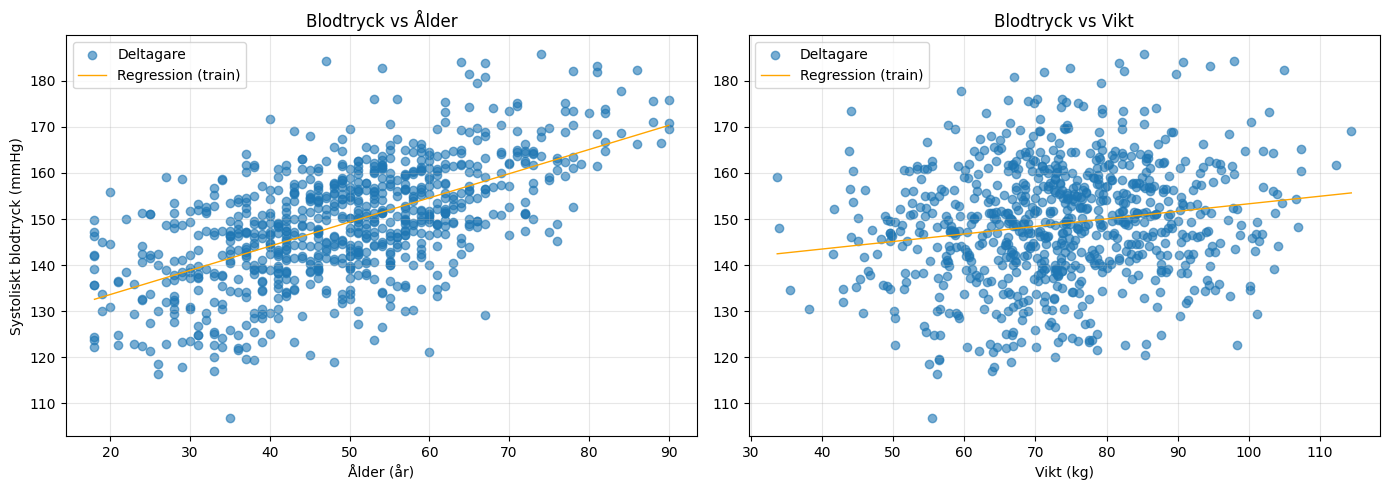

In [10]:
# 1. Data + gemensam test/split
# ===============================
y = dh.df["systolic_bp"].values

# Skapa index-split
train_idx, test_idx = train_test_split(dh.df.index, test_size=0.2, random_state=42)

# Skapa tre olika X-matriser - test & train
X_age_train = dh.df.loc[train_idx, ["age"]].values
X_age_test = dh.df.loc[test_idx, ["age"]].values

X_weight_train = dh.df.loc[train_idx, ["weight"]].values
X_weight_test = dh.df.loc[test_idx, ["weight"]].values

X_multi_train = dh.df.loc[train_idx, ["age", "weight"]].values
X_multi_test = dh.df.loc[test_idx, ["age", "weight"]].values

y_train = dh.df.loc[train_idx, "systolic_bp"].values
y_test  = dh.df.loc[test_idx, "systolic_bp"].values

# 2. Träna modellen
# ===============================
# Enkel regression: age
model_age = LinearRegression()
model_age.fit(X_age_train, y_train)

# Enkel regression: weight
model_weight = LinearRegression()
model_weight.fit(X_weight_train, y_train)

# Multipel regression: age + weight
model_multi = LinearRegression()
model_multi.fit(X_multi_train, y_train)

# 3. Utvärdera modellen
# ===============================
def evaluate(model, X_test, name):
    """
    Utvärderar en tränad regressionsmodell på testdata och skriver ut RMSE och R².
    
    model : object
        En tränad modell med metoderna .predict() och .score().
    X_test : array-like
        Testdata som används för prediktion.
    name : str
        Namnet som ska visas i utskriften.
    """
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = model.score(X_test, y_test)
    r2_percent = r2 * 100
    print(f"{name:<20}:\n  RMSE: {rmse:.2f}     R²: {r2_percent:.1f} %\n")


print("Testresultat")
print("=====================================")
evaluate(model_age,    X_age_test,   "Enkel regression (age)")
evaluate(model_weight, X_weight_test,"Enkel regression (weight)")
evaluate(model_multi,  X_multi_test, "Multipel regression")

# 4. Exempelprediktion med multipel modell
# ===============================
pred = model_multi.predict(np.array([[40, 80]]))[0]
coef_age, coef_weight = model_multi.coef_

print("Exempelprognos")
print("=====================================")
print(f"Blodtryck för 40 år och 80 kg ≈ {pred:.1f} mmHg")
print(f"""
Koefficient - ålder:    {coef_age:.2f} mmHg
Koefficient - vikt:     {coef_weight:.2f} mmHg
""")

# 5. Enkel regression: Scatterplots
# ===============================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Scatter 1: BP vs Age ---
x_age_full = dh.df[["age"]].values
y_full = dh.df["systolic_bp"].values

x_line_age = np.linspace(x_age_full.min(), x_age_full.max(), 100).reshape(-1, 1)
y_line_age = model_age.predict(x_line_age)

axes[0].scatter(x_age_full, y_full, alpha=0.6, label="Deltagare")
axes[0].plot(x_line_age, y_line_age, color="orange", linewidth=1, label="Regression (train)")
axes[0].set_xlabel("Ålder (år)")
axes[0].set_ylabel("Systoliskt blodtryck (mmHg)")
axes[0].set_title("Blodtryck vs Ålder")
axes[0].grid(alpha=0.3)
axes[0].legend()

# --- Scatter 2: BP vs Weight ---
x_weight_full = dh.df[["weight"]].values
x_line_weight = np.linspace(x_weight_full.min(), x_weight_full.max(), 100).reshape(-1, 1)
y_line_weight = model_weight.predict(x_line_weight)

axes[1].scatter(x_weight_full, y_full, alpha=0.6, label="Deltagare")
axes[1].plot(x_line_weight, y_line_weight, color="orange", linewidth=1, label="Regression (train)")
axes[1].set_xlabel("Vikt (kg)")
axes[1].set_title("Blodtryck vs Vikt")
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

#### Tolkning av resultatet

**Samband mellan ålder och systoliskt blodtryck**

- **R^2 ≈ 39,5 %:** Ålder förklarar en relativt stor del av variationen i systoliskt blodtryck
- **RMSE ≈ 10 mmHg:** Genomsnittligt prediktionsfel motsvarar ungefär 10 mmHg

Scatterploten visar ett tydligt positivt linjärt samband: högre ålder tenderar att hänga ihop med högre blodtryck. Detta syns även i regressionslinjen som lutar uppåt.

**Samband mellan vikt och systoliskt blodtryck**

- **R^2 ≈ 3 %:** Vikt förklarar nästan ingen variation i blodtrycket.
- **RMSE ≈ 12,6 mmHg:** Genomsnittligt prediktionsfel motsvarar ungefär 12,6 mmHg, vilket är högst fel av modellerna.

Scatterploten visar ett svagt och mer utspritt mönster, vilket förklarar den låga förklaringsgraden. Sambandet mellan vikt och blodtryck verkar alltså vara mycket svagare än sambandet med ålder.

**Multipel regression (ålder + vikt)**

- **R^2 ≈ 42,5 %:** Ålder och vikt tillsammans har en måttlig förklaringsgrad till ökat systoliskt blodtryck, men resterande 57 % förklaras av andra faktorer än vikt och ålder. 
- **RMSE ≈ 9,72 mmHg:** Genomsnittligt prediktionsfel motsvarar ungefär 9,72 mmHg, vilket är lägst fel av modellerna. 

Detta visar att vikt bidrar något utöver ålder, men att ålder är den klart dominerande faktorn för ett förhöjt systoliskt blodtryck. 

**Koefficienter och prediktion**

- **0,53 mmHg per år:** Blodtrycket ökar i genomsnitt ungefär ett halvt mmHg per levandsår. 
- **0,18 mmHg per kg:** Ökad vikt har en positiv men betydligt svagare effekt på ökat blodtryck. 

## Principle Component Analysis (PCA)

*Principle Component Analysis (PCA)* bygger på egenvärdesdekomposition och används för att reducera dimensioner och identifiera strukturer i datan utan att förlora viktig information. Komplexa datamängder kan förändras genom att omvandla korrelerade funktioner (*features*) till en mindre uppsättning okorrelerade komponenter (*components*). PCA använder linjär algebra för att omvandla data till nya funktioner som kallas huvudkomponenter (*principal components*). PCA väljer sedan ut de högsta komponenterna med de högsta egenvärdena och projicerar data på dem för att förenkla datamängden.

PCA baseras på numeriska, kontinuerliga variabler därför kommer endast dessa plockas ut från datasetet för analys. Kategoriska variabler, så som kön, används sedan för tolkning.

**Källa**: *Videolektioner från kursen Pythonprogrammering och statistisk dataanalys*, *[Geeks for geeks - Principal Component Analysis (PCA)](https://www.geeksforgeeks.org/data-analysis/principal-component-analysis-pca/)*

In [11]:
features = ["age", "height", "weight", "systolic_bp", "cholesterol"]
X = dh.df[features].values

# Standardisera datan --> all features have mean = 0 and standard deviation = 1
X_scaled = StandardScaler().fit_transform(X)

# Beräkna kovariansmatrisen med samtliga komponenter (5 st)
pca_full = PCA()
pca_full.fit(X_scaled)

expl_var = pca_full.explained_variance_ratio_

### Översikt huvudkomponenter
Här visas en sammanställning över funktionerna i datasetet relaterar till varandra oavsett om de ökar eller minskar tillsammans. Värdena kan vara positiva, negativa eller nollor. *Scree ploten* visar den förklarade variansen för de olika kompnenterna. PC1 har rikningen för maximal varians, alltså störst spridning och PC2 har näst störs spridning och kommer att anändas för vidare analys.

Översikt Principle Components
          age    height    weight  systolic_bp  cholesterol
PC1  0.573224  0.098300  0.247196     0.568990     0.526209
PC2 -0.279984  0.693791  0.657227    -0.059119    -0.069424
PC3  0.277281  0.556410 -0.495263     0.317787    -0.516961
PC4 -0.142505 -0.432574  0.387781     0.570396    -0.562891
PC5  0.704153 -0.110805  0.333596    -0.496402    -0.366319


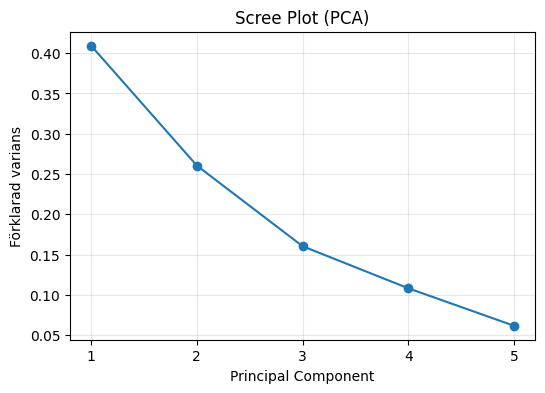

In [12]:
# Översikt Principle Components - tabell
# ========================
loading_df = pd.DataFrame(
    pca_full.components_,
    columns=features,
    index=[f"PC{i+1}" for i in range(len(features))]
)

print("Översikt Principle Components")
print("=====================================")
print(loading_df)
print("=====================================")

# Översikt Principle Components - Scree plot
# ========================
plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(expl_var)+1), expl_var, marker='o')
plt.xticks(np.arange(1, len(expl_var)+1))
plt.xlabel("Principal Component")
plt.ylabel("Förklarad varians")
plt.title("Scree Plot (PCA)")
plt.grid(alpha=0.3)
plt.show()

### PCA med två huvudkomponenter
Här visas den transformerade datan med hjälp av de två huvudkomponenterna (PC1 & PC2). Dessa komponenter fångar den maximala variansen, vilket ofta visar bättre klasseparation och struktur, vilket gör det lättare att analysera data med många variablar.

- PC1: ålder, blodtryck och kolesterol (och lite vikt)
- PC 2: längd och vikt

Nedan visas PCA med två komponenter där den kategoriska variablen kön används för att tolka resultatet. 

PC1: 40.9%
PC2: 26.0%


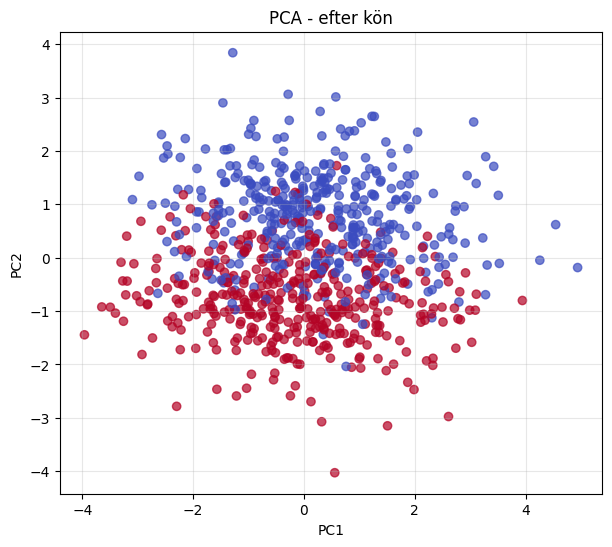

In [13]:
# PCA med 2 högsta huvudkomponenter (PC1 & PC2)
# ========================
pca = PCA(n_components=2)
PCs = pca.fit_transform(X_scaled)

print("=====================================")
print(f"PC1: {pca.explained_variance_ratio_[0] * 100:.1f}%")
print(f"PC2: {pca.explained_variance_ratio_[1] * 100:.1f}%")
print("=====================================")

# Visualiserar PC1 & PC2 i en Scatter plot
# ========================
plt.figure(figsize=(7,6))
plt.scatter(PCs[:,0], PCs[:,1], c=dh.df["sex"].map({"M":0, "F":1}), cmap="coolwarm", alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA - efter kön")
plt.grid(alpha=0.3)
plt.show()

### Tolkning av resultatet

- PC1 förklarar 40.9 % av variationen och domineras av ålder, systoliskt blodtryck och kolesterol. Detta tyder på att PC1 kan tolkas som en allmän ”kardiovaskulär riskfaktor”, där högre värden indikerar högre riskprofil.
- PC2 förklarar 26.0 % av variationen och domineras av längd och vikt. Man kan säga att PC2 representera kroppsstorlek, där högre värden motsvarar längre och tyngre personer.

PCA-grafen visar att:
- Det är en större spridning längs PC1 än PC2, vilket är väntat eftersom PC1 förklarar mest varians (40.9 %) och representeras av ålder, blodtryck och kolesterol. Det betyder att dessa faktorer varierar mer mellan personer än kroppsstorlek, som PC2 representerar. 
- Män klustrar högre längs PC2-axeln, vilket betyder att män är i snitt längre och tyngre än kvinnor vilket ger en tydlig könsseperation vertikalt i grafen. 
- Liten eller ingen skilland mellan kön längs PC1-axeln vilket betyder att ålder, blodtryck och kolesterol skiljer sig inte tydligt mellan könen i detta dataset.